# EE275 Mini Project III (Fall 2022)

## Project: Cache Simulator

#### Created By: Bhavin Patel (015954770)

In [1]:
import math
import random
from enum import Enum
import matplotlib.pyplot as plt
import pandas as pd

trc_limit=1.0 # % of trace to process [ between 0.0 to 1.0], reduce it for shorter simulation

#### Reading Address Trace

In [2]:
lines = ()
with open("addr_trace.txt", "r") as f:
    lines = f.read().splitlines();
    
addr_trace = [int(i) for i in lines]
#print (addr_trace)

#### Translating Trace

In [3]:
prevAddr = 0
for idx in range(len(addr_trace)):
    addr_trace[idx] += prevAddr
    prevAddr = addr_trace[idx]
#print (addr_trace)

### Main Memory Implementation

In [4]:
# Main memory reads are supported simply by returning a line of random bytes
def getRandDataLine(b_size):
    line = []
    for i in range(b_size):
        line.append(random.randint(0,pow(2,8))) ## every location holds 8-bit of data
    return line

### Performance Recorder

In [5]:
## Recorder tracks all the hits/misses
class Recorder:
    
    def __init__(self):
        self.history = []
        self.hitCount = 0;
        self.missCount = 0;
        self.hitRate = 0.0;
        self.total = 0;
        
    # called when after a read is processed
    def record(self, addr, hit):
        self.history.append({'addr': addr, 'hit': hit});
        if(hit):
            self.hitCount += 1
        else:
            self.missCount += 1
        self.hitRate = (self.hitCount / (self.hitCount + self.missCount)) * 100.0
        self.total = self.hitCount + self.missCount
    
    # show total hits and misses
    def showRecord(self):
        print("Total:", self.total,
              "Hit:", self.hitCount,
              "Miss:", self.missCount,
              "hitRate(%)=", '{0:.3f}'.format(self.hitRate))
     
    # show hits and misses for each address reads in trace
    def showHistory(self):
        for item in self.history:
            print('{0: >15}'.format(item['addr']), ' ', '{0: >5}'.format(item['hit']))
        
        

### Replacement Policy Manager

In [6]:
# Enum for replacement policies
class Policy(Enum):
    LRU = 1
    FIFO = 2
    RANDOM = 3

In [7]:
# ReplacementPolicy: Keeps track of all the reads for LRU, FIFO and Random policies
class ReplacementPolicy:
    
    def __init__(self, associativity, policy):
        self.associativity = associativity
        self.policy = policy
        self.entryQueue = []
        self.usedQueue = []
        for i in range(associativity):
            self.usedQueue.append(0)
        
    # called when a line is loaded from MM to Cache
    def reportLoad(self, lineNum):
        
        # for FIFO : update the FIFO queue
        self.entryQueue.append(lineNum)
        if(len(self.entryQueue) > self.associativity):
            self.entryQueue.pop(0)
            
        #for LRU : initialize the 'used count' for the loaded line
        self.usedQueue[lineNum] = 1

    # called when a line in cache needs to be replaced
    # returns the line number to replace
    def getLoadableIdx(self):
        
        # for FIFO: pop from the front of FIFO queue
        if(self.policy == Policy.FIFO):
            if(len(self.entryQueue) == 0):
                return 0
            elif(len(self.entryQueue) < self.associativity):
                return len(self.entryQueue)
            else:
                return self.entryQueue[0]
            
        # for LRU: get the line that has the lowest 'used count'
        elif(self.policy == Policy.LRU):
            tmp = min(self.usedQueue)
            return self.usedQueue.index(tmp)
        
        # for RANDOM: just return the random line
        else: 
            return random.randint(0,self.associativity-1)
            
    # called when a line is read
    # LRU updates the line count accordingly
    def reportLookup(self, lineNum):
        self.usedQueue[lineNum] += 1

## Cache Implementation

#### 1. Cache Structure

In [8]:
######## a single cache Line ########
class CacheLine:
    
    def __init__(self, blockSize, associativity):
        self.cBlocks = []
        self.tag = 0;
        self.associativity = associativity
        for i in range(blockSize):
            self.cBlocks.append(0)
        
    # show the line
    def show(self, setNum, lineNum):
        frmt = "{:>5}"*len(self.cBlocks)
        print("set=", '{0: >5}'.format(setNum), " | line=", '{0: >5}'.format(lineNum + setNum * self.associativity), " | ", frmt.format(*self.cBlocks))
    
    # find given block in the cache line
    def lookup(self, lookupObj):
        lookupObj.data = self.cBlocks[lookupObj.offset]
     
    # load the cache line with new data
    def load(self, loadObj):
        self.tag = loadObj.tag
        self.cBlocks = loadObj.dataList
   
######## a single set of Cache ########
class CacheSet:
 
    def __init__(self, linesInSet, blockSize, associativity, policy):
        # create multiple cache lines
        self.rPolicy = ReplacementPolicy(associativity, policy)
        self.cLines = []
        self.associativity = associativity
        for i in range(linesInSet):
            self.cLines.append(CacheLine(blockSize, associativity))
    
    # show the set
    def show(self, setNum):
        for lineNum in range(len(self.cLines)):
            self.cLines[lineNum].show(setNum, lineNum)
    
    # find the given line in this set
    def lookup(self, lookupObj):
        lookupObj.hit = False;
        lookupObj.data = 0;
        for i in range(len(self.cLines)):
            if(self.cLines[i].tag == lookupObj.tag): #hit
                lookupObj.hit = True
                lookupObj.line = i
                self.cLines[i].lookup(lookupObj)
                self.rPolicy.reportLookup(i)
    
    # load one of the lines in set with given data
    def load(self, loadObj):
        loadIdx = self.rPolicy.getLoadableIdx()
        self.cLines[loadIdx].load(loadObj)
        self.rPolicy.reportLoad(loadIdx)
        
        
######## Main Cache ########
class Cache:

    def __init__(self, cacheSize, blockSize, associativity, policy):
        self.recorder=Recorder();
        # create multiple cache sets
        numOfLines = cacheSize // blockSize
        numOfSets = numOfLines // associativity
        linesInSet = numOfLines // numOfSets
        self.cSets = []
        for i in range(numOfSets):
            self.cSets.append(CacheSet(linesInSet, blockSize, associativity, policy))
    
    # show the cache contents
    def show(self):
        for setNum in range(len(self.cSets)):            
            print("---------------------------")
            self.cSets[setNum].show(setNum)
    
    # find the given physical address in cache
    def lookup(self, lookupObj):
        self.cSets[lookupObj.set].lookup(lookupObj)
        self.recorder.record(lookupObj.addr, lookupObj.hit)
        
    # load the given data in cache line
    def load(self, loadObj):
        self.cSets[loadObj.set].load(loadObj)
        


#### 2. Cache Lookup and Load information

In [9]:
### Lookup Object: this object holds all the information about an instance of cache read operation
class LookUpObj:
    def __init__(self,  addr, n_tag, n_set, n_offset):
        self.addr = addr
        self.tag = int(addr) >> (n_set + n_offset) & ((1 << n_tag) - 1)
        self.set = int(addr) >> (n_offset) & ((1 << n_set) - 1)
        self.offset = int(addr) & ((1 << n_offset) - 1)
        self.data = 0
        self.line = -1
        self.hit = False
    
    def show(self):
        print("addr=", '{0: >10}'.format(self.addr),
              "TAG: ", '{0: >5}'.format(self.tag),
              "SET:", '{0: >5}'.format(self.set),
              "OFFSET:", '{0: >5}'.format(self.offset),
              " | data=", '{0: >5}'.format(self.data),
              "line=", '{0: >5}'.format(self.line),
              "hit:", '{0: >5}'.format(self.hit))

### Load Object: this object holds all the information about an instance of data to be loaded in a cache 
class LoadObj:
    def __init__(self,  addr, dataList, n_tag, n_set, n_offset):
        self.addr = addr
        self.tag = int(addr) >> (n_set + n_offset) & ((1 << n_tag) - 1)
        self.set = int(addr) >> (n_offset) & ((1 << n_set) - 1)
        self.offset = int(addr) & ((1 << n_offset) - 1)
        self.dataList = dataList
        
    def show(self):
        print("addr=", '{0: >10}'.format(self.addr),
              "TAG: ", '{0: >5}'.format(self.tag),
              "SET:", '{0: >5}'.format(self.set),
              "OFFSET:", '{0: >5}'.format(self.offset),
              " | data=", *self.dataList)

## Parameterized Cache Simulation Function

In [10]:
### Main function to simulate the cache for given cache parameters:
#   1. cache size    
#   2. block size.   
#   3. associativity.   
#   4. replacement policy

def simulateCache(cSize, bSize, assoc, pol):

    ############## set-up the cache parameters ###########
    CACHE_SIZE=cSize * 1024 #bytes
    BLOCK_SIZE=bSize #bytes
    ASSOCIATIVITY=assoc
    POLICY=pol
    print ("")
    print ("Cache Size: {0}K".format(cSize), "Block Size:", bSize, "Associativity:", assoc, "Policy:", POLICY.name)

    ## number of address bits, offset bits, set bits, tag bits
    ADDR_SIZE=32
    N_OFFSET=int(math.log2(BLOCK_SIZE))
    N_SET=int(math.log2(((CACHE_SIZE//BLOCK_SIZE)//ASSOCIATIVITY)))
    N_TAG=ADDR_SIZE - N_OFFSET - N_SET
    print ("TAG-bits:", N_TAG, "SET-bits:", N_SET, "OFFSET-bits:", N_OFFSET, )
    
    ############### create cache ##############
    cache = Cache(CACHE_SIZE, BLOCK_SIZE, ASSOCIATIVITY, POLICY)
    #cache.show()
    
    ############### look for each addresses given in trace ##############
    for idx in range(len(addr_trace)):
        lookupObj = LookUpObj(addr_trace[idx], N_TAG, N_SET, N_OFFSET)
        #lookupObj.show()
        cache.lookup(lookupObj)
        #lookupObj.show()

        # load data if you get a miss
        if(lookupObj.hit == False):
            loadDataLine = getRandDataLine(BLOCK_SIZE)    
            loadObj = LoadObj(lookupObj.addr, loadDataLine, N_TAG, N_SET, N_OFFSET)
            #print("loading data line(to set {0}): {1}".format(loadObj.set, loadDataLine))
            cache.load(loadObj)

        # limited to first N address for testing
        if(idx >= (len(addr_trace) * trc_limit)):
            break

    # show cache again to see that the data loaded
    #cache.show()
    
    # show statistics 
    cache.recorder.showRecord()  
    #cache.recorder.showHistory()
    
    return cache.recorder.hitRate
    

## Simulate Cache for Different Combinations of: cache-size, block-size, associativity 

Scenario-1 : fixed(block-size=32-Bytes, Associativity:4) Varying(Cache-size: 16KB to 128KB)
---------------

Cache Size: 16K Block Size: 32 Associativity: 4 Policy: LRU
TAG-bits: 20 SET-bits: 7 OFFSET-bits: 5
Total: 1500000 Hit: 1475924 Miss: 24076 hitRate(%)= 98.395

Cache Size: 16K Block Size: 32 Associativity: 4 Policy: FIFO
TAG-bits: 20 SET-bits: 7 OFFSET-bits: 5
Total: 1500000 Hit: 1483523 Miss: 16477 hitRate(%)= 98.902

Cache Size: 16K Block Size: 32 Associativity: 4 Policy: RANDOM
TAG-bits: 20 SET-bits: 7 OFFSET-bits: 5
Total: 1500000 Hit: 1481216 Miss: 18784 hitRate(%)= 98.748
---------------

Cache Size: 32K Block Size: 32 Associativity: 4 Policy: LRU
TAG-bits: 19 SET-bits: 8 OFFSET-bits: 5
Total: 1500000 Hit: 1491950 Miss: 8050 hitRate(%)= 99.463

Cache Size: 32K Block Size: 32 Associativity: 4 Policy: FIFO
TAG-bits: 19 SET-bits: 8 OFFSET-bits: 5
Total: 1500000 Hit: 1491575 Miss: 8425 hitRate(%)= 99.438

Cache Size: 32K Block Size: 32 Associativity: 4 Policy: RANDOM
TAG-bits:

,LRU,FIFO,RANDOM
Cache Size,,,
16,1.605067,1.098467,1.252267
32,0.536667,0.561667,0.604467
64,0.265000,0.374800,0.387067
128,0.197467,0.222000,0.269333


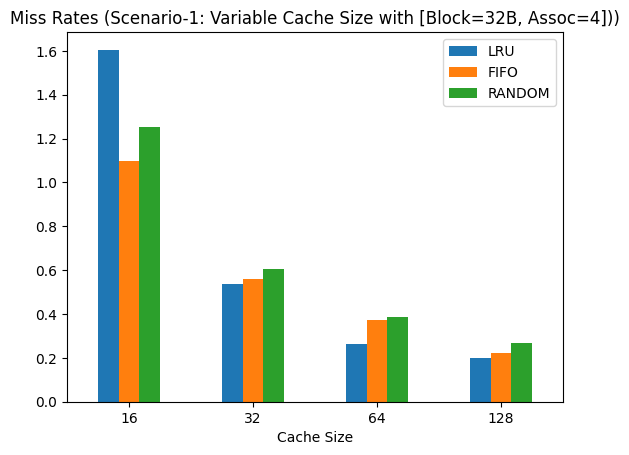

Scenario-2 : fixed(cache-size=32KB, Associativity:4) Varying(Block-size: 16-Bytes to 128-Bytes)
---------------

Cache Size: 32K Block Size: 16 Associativity: 4 Policy: LRU
TAG-bits: 19 SET-bits: 9 OFFSET-bits: 4
Total: 1500000 Hit: 1490113 Miss: 9887 hitRate(%)= 99.341

Cache Size: 32K Block Size: 16 Associativity: 4 Policy: FIFO
TAG-bits: 19 SET-bits: 9 OFFSET-bits: 4
Total: 1500000 Hit: 1488888 Miss: 11112 hitRate(%)= 99.259

Cache Size: 32K Block Size: 16 Associativity: 4 Policy: RANDOM
TAG-bits: 19 SET-bits: 9 OFFSET-bits: 4
Total: 1500000 Hit: 1488389 Miss: 11611 hitRate(%)= 99.226
---------------

Cache Size: 32K Block Size: 32 Associativity: 4 Policy: LRU
TAG-bits: 19 SET-bits: 8 OFFSET-bits: 5
Total: 1500000 Hit: 1491950 Miss: 8050 hitRate(%)= 99.463

Cache Size: 32K Block Size: 32 Associativity: 4 Policy: FIFO
TAG-bits: 19 SET-bits: 8 OFFSET-bits: 5
Total: 1500000 Hit: 1491575 Miss: 8425 hitRate(%)= 99.438

Cache Size: 32K Block Size: 32 Associativity: 4 Policy: RANDOM
TAG-bi

,LRU,FIFO,RANDOM
Block Size,,,
16,0.659133,0.740800,0.774067
32,0.536667,0.561667,0.605267
64,0.514000,0.431333,0.471867
128,0.511933,0.362400,0.403200


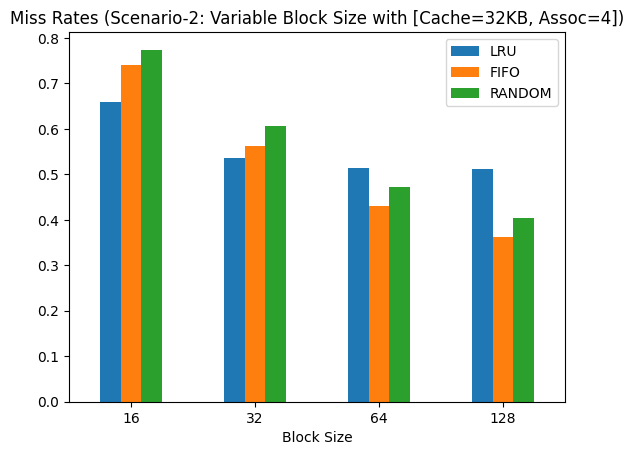

Scenario-3 : fixed(block-size=32-Bytes, cache-size:8KB) Varying(Associativity: 1, 2,.. to fully-associative)
---------------

Cache Size: 8K Block Size: 32 Associativity: 1 Policy: LRU
TAG-bits: 19 SET-bits: 8 OFFSET-bits: 5
Total: 1500000 Hit: 1365252 Miss: 134748 hitRate(%)= 91.017

Cache Size: 8K Block Size: 32 Associativity: 1 Policy: FIFO
TAG-bits: 19 SET-bits: 8 OFFSET-bits: 5
Total: 1500000 Hit: 1365252 Miss: 134748 hitRate(%)= 91.017

Cache Size: 8K Block Size: 32 Associativity: 1 Policy: RANDOM
TAG-bits: 19 SET-bits: 8 OFFSET-bits: 5
Total: 1500000 Hit: 1365252 Miss: 134748 hitRate(%)= 91.017
---------------

Cache Size: 8K Block Size: 32 Associativity: 4 Policy: LRU
TAG-bits: 21 SET-bits: 6 OFFSET-bits: 5
Total: 1500000 Hit: 1397709 Miss: 102291 hitRate(%)= 93.181

Cache Size: 8K Block Size: 32 Associativity: 4 Policy: FIFO
TAG-bits: 21 SET-bits: 6 OFFSET-bits: 5
Total: 1500000 Hit: 1449874 Miss: 50126 hitRate(%)= 96.658

Cache Size: 8K Block Size: 32 Associativity: 4 Policy:

,LRU,FIFO,RANDOM
Associativity,,,
1,8.983200,8.983200,8.983200
4,6.819400,3.341733,3.686733
8,7.700000,2.649400,3.054800
16,8.579200,2.323867,2.752467
32,11.008933,2.291000,2.716667
256,18.127000,2.236867,2.681800


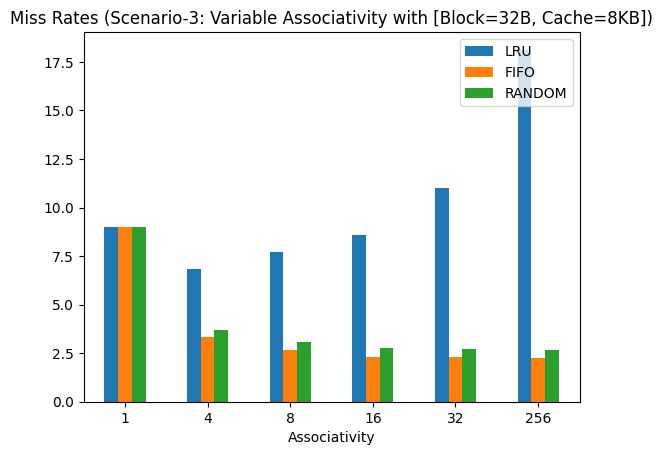

In [11]:
########### Simulate cache for different combinations of each parameters ###########

cache_size_KB = [16, 32, 64, 128]
block_size_B = [16, 32, 64, 128]
associativity_N=[1,4,8, 16, 32]
policies=[Policy.LRU, Policy.FIFO, Policy.RANDOM]

## function to plot a chart
def plotHits(ht, label, colName):
    df = pd.DataFrame(ht)
    df.set_index(colName, inplace=True)
    display(df)
    df.plot.bar(rot=0)
    plt.title("Miss Rates ({0})".format(label))
    plt.legend(loc='upper right')
    plt.show()

############  Scenario 1  ############
print("Scenario-1 : fixed(block-size=32-Bytes, Associativity:4) Varying(Cache-size: 16KB to 128KB)")
allHits = []
label = 'Scenario-1: Variable Cache Size with [Block=32B, Assoc=4])'
colName = 'Cache Size'
for cs in cache_size_KB:    
    print ("---------------")
    hits = {}
    for pol in policies:
        hits[pol.name] = 100.0 - simulateCache(cs, 32, 4, pol)
    hits[colName] = cs
    allHits.append(hits)
plotHits(allHits, label, colName)

############  Scenario 2  ############
print ("Scenario-2 : fixed(cache-size=32KB, Associativity:4) Varying(Block-size: 16-Bytes to 128-Bytes)")
allHits = []
label = 'Scenario-2: Variable Block Size with [Cache=32KB, Assoc=4]'
colName = 'Block Size'
for bs in block_size_B:    
    print ("---------------")
    hits = {}
    for pol in policies:
        hits[pol.name] = 100.0 - simulateCache(32, bs, 4, pol)
    hits[colName] = bs        
    allHits.append(hits)
plotHits(allHits, label, colName)

############  Scenario 3  ############
print("Scenario-3 : fixed(block-size=32-Bytes, cache-size:8KB) Varying(Associativity: 1, 2,.. to fully-associative)")
allHits = []
label = 'Scenario-3: Variable Associativity with [Block=32B, Cache=8KB]'
colName = 'Associativity'
associativity_N.append((8 * 1024) // 32) #append full-assoc.: 8KB(cache-size)/32B[block-size]
for assoc in associativity_N:    
    print ("---------------")
    hits = {}
    for pol in policies:
        hits[pol.name] = 100.0 - simulateCache(8, 32, assoc, pol)
    hits[colName] = assoc
    allHits.append(hits)
plotHits(allHits, label, colName)
